In [31]:
import altair as alt
from augur.utils import json_to_tree
import json
import pandas as pd

In [34]:
# Import modules
import gzip
import json
import urllib3
import requests
import json
json_tree_handle = json.loads(requests.get("http://data.nextstrain.org/zika_tree.json").text)
# Download tree JSON file used by auspice. Despite its filename extension, the data are compressed.
#http = urllib3.PoolManager()
# = http.request('GET', "")


In [35]:
tree = json_to_tree(json_tree_handle)

In [36]:
tree

Clade(branch_length=0, clade=939, name='NODE_0000520', numdate=2007.1351029672512, strain='NODE_0000520', yvalue=511.9124154362944)

In [37]:
node_data = [
    {
        "name": node.name,
        "date": node.attr["num_date"],
        "y": node.yvalue,
        "region": node.attr["region"],
        "country": node.attr["country"],
        "parent_date": node.parent is not None and node.parent.attr["num_date"] or node.attr["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue
    }
    for node in tree.find_clades()
]

In [38]:
node_data[10]

{'name': 'NODE_0000345',
 'date': 2008.612122972273,
 'y': 507.4498308725888,
 'region': 'southeast_asia',
 'country': 'thailand',
 'parent_date': 2007.1351029672512,
 'parent_y': 511.9124154362944}

In [39]:
node_df = pd.DataFrame(node_data)

In [40]:
node_df.head()

,country,date,name,parent_date,parent_y,region,y
0,thailand,2007.135103,NODE_0000520,2007.135103,511.912415,southeast_asia,511.912415
1,thailand,2008.570845,NODE_0000346,2007.135103,511.912415,southeast_asia,516.375000
2,thailand,2010.979423,NODE_0000347,2008.570845,516.375000,southeast_asia,517.500000
3,thailand,2013.136893,THA/PLCal_ZV/2013,2010.979423,517.500000,southeast_asia,518.000000
4,thailand,2016.665298,SI_BKK01,2010.979423,517.500000,southeast_asia,517.000000


In [41]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [42]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [43]:
node_df.shape

(940, 7)

In [44]:
node_df.head()

,country,date,name,parent_date,parent_y,region,y
0,thailand,2007.135103,NODE_0000520,2007.135103,5.587585,southeast_asia,6.087585
1,thailand,2008.570845,NODE_0000346,2007.135103,5.587585,southeast_asia,1.625000
2,thailand,2010.979423,NODE_0000347,2008.570845,1.125000,southeast_asia,0.500000
3,thailand,2013.136893,THA/PLCal_ZV/2013,2010.979423,0.000000,southeast_asia,0.000000
4,thailand,2016.665298,SI_BKK01,2010.979423,0.000000,southeast_asia,1.000000


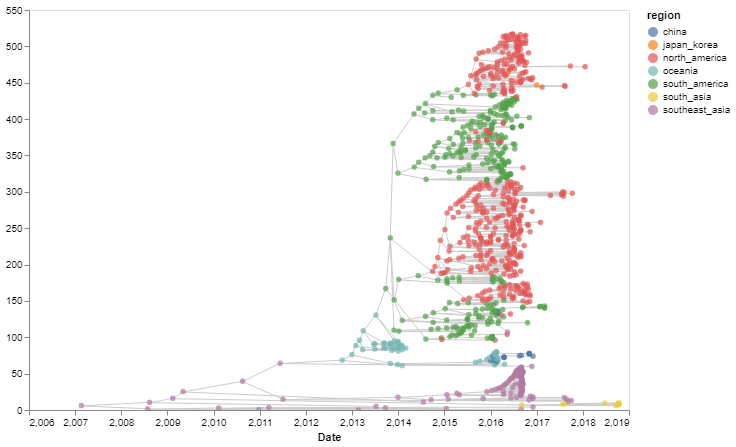

In [45]:
base = alt.Chart(node_df)

tips = base.mark_circle().encode(
    x=alt.X(
        "date:Q",
        scale=alt.Scale(domain=(node_df["date"].min() - 0.2, node_df["date"].max() + 0.2)),
        axis=alt.Axis(grid=False),
        title="Date",
    ),
    y=alt.Y(
        "y:Q",
        title="",
        axis=alt.Axis(grid=False),
    ),
    color="region:N",
    tooltip=["name:N", "region:N", "date:Q"]
)
lines = base.mark_line().encode(
    x=alt.X("parent_date:Q", scale=alt.Scale(domain=(node_df["date"].min() - 0.2, node_df["date"].max() + 0.2))),
    x2="date:Q",
    y="parent_y:Q",
    y2="y:Q",
    color=alt.ColorValue("#cccccc")
)
(lines + tips).properties(
    width=600,
    height=400
).interactive()